# CUDA Memory Transfer Performance Analysis

This notebook compares pageable (`new[]`) vs pinned (`cudaHostAlloc`) memory transfer performance for GPU operations.

In [22]:
import subprocess
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Compile the program first
print("Compiling compare_mem_access...")
print(os.getcwd())
result = subprocess.run(['make', 'compare_mem_access'],
                       cwd='./')
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Compiling compare_mem_access...
/home/friday/nvme/workspace/ECE455/Proj
Auto-detected GPU with SM 87
Building for ARM (Jetson) with SM 87
/usr/local/cuda/bin/nvcc -O3 -use_fast_math -Xcompiler -Wall -Xcompiler -Wextra -Xcompiler -fopenmp -gencode arch=compute_87,code=sm_87 -c compare_mem_access.cu -o compare_mem_access.o
/usr/local/cuda/bin/nvcc -O3 -use_fast_math -Xcompiler -Wall -Xcompiler -Wextra -Xcompiler -fopenmp -gencode arch=compute_87,code=sm_87 -o compare_mem_access compare_mem_access.o -lgomp -lnvidia-ml
/usr/local/cuda/bin/nvcc -O3 -use_fast_math -Xcompiler -Wall -Xcompiler -Wextra -Xcompiler -fopenmp -gencode arch=compute_87,code=sm_87 -o compare_mem_access compare_mem_access.o -lgomp -lnvidia-ml
✓ Compilation successful
✓ Compilation successful


# Compare memory access: pageable vs. pinned

In [23]:
# Run benchmarks
test_sizes = [64, 128, 256, 512, 1024]
csv_file = './compare_mem_access_output.csv'
num_runs = 5

# Collect data from each run
all_data = []
for size in tqdm(test_sizes, desc="Test sizes", unit="size"):
    for run in tqdm(range(num_runs), desc=f"{size} MB", unit="run"):
        subprocess.run(['./compare_mem_access', str(size)],
                       cwd='./',
                       capture_output=True)
        # Read CSV after each run and accumulate
        run_df = pd.read_csv(csv_file)
        all_data.append(run_df)

# Combine all runs and calculate averages
raw_df = pd.concat(all_data, ignore_index=True)
df = raw_df.groupby(['size_mb', 'memory_type']).mean().reset_index()
print(f"\nCollected {len(raw_df)} measurements, averaged to {len(df)} results")
df

Test sizes: 100%|██████████| 5/5 [00:37<00:00,  7.58s/size]




Collected 75 measurements, averaged to 15 results


,size_mb,memory_type,h2d_ms,h2d_gbps,d2h_ms,d2h_gbps
0,64,Managed,0.036,1767.578,0.318,197.662
1,64,Pageable,10.684,5.968,9.916,6.304
2,64,Pinned,2.668,23.432,2.632,23.736
3,128,Managed,0.040,3472.220,0.640,195.804
4,128,Pageable,18.620,6.714,18.836,6.636
5,128,Pinned,5.242,23.846,5.212,23.996
6,256,Managed,0.040,7063.492,1.300,192.538
7,256,Pageable,35.992,6.948,36.652,6.820
8,256,Pinned,10.414,24.006,10.384,24.068
9,512,Managed,0.040,13893.178,2.618,190.818


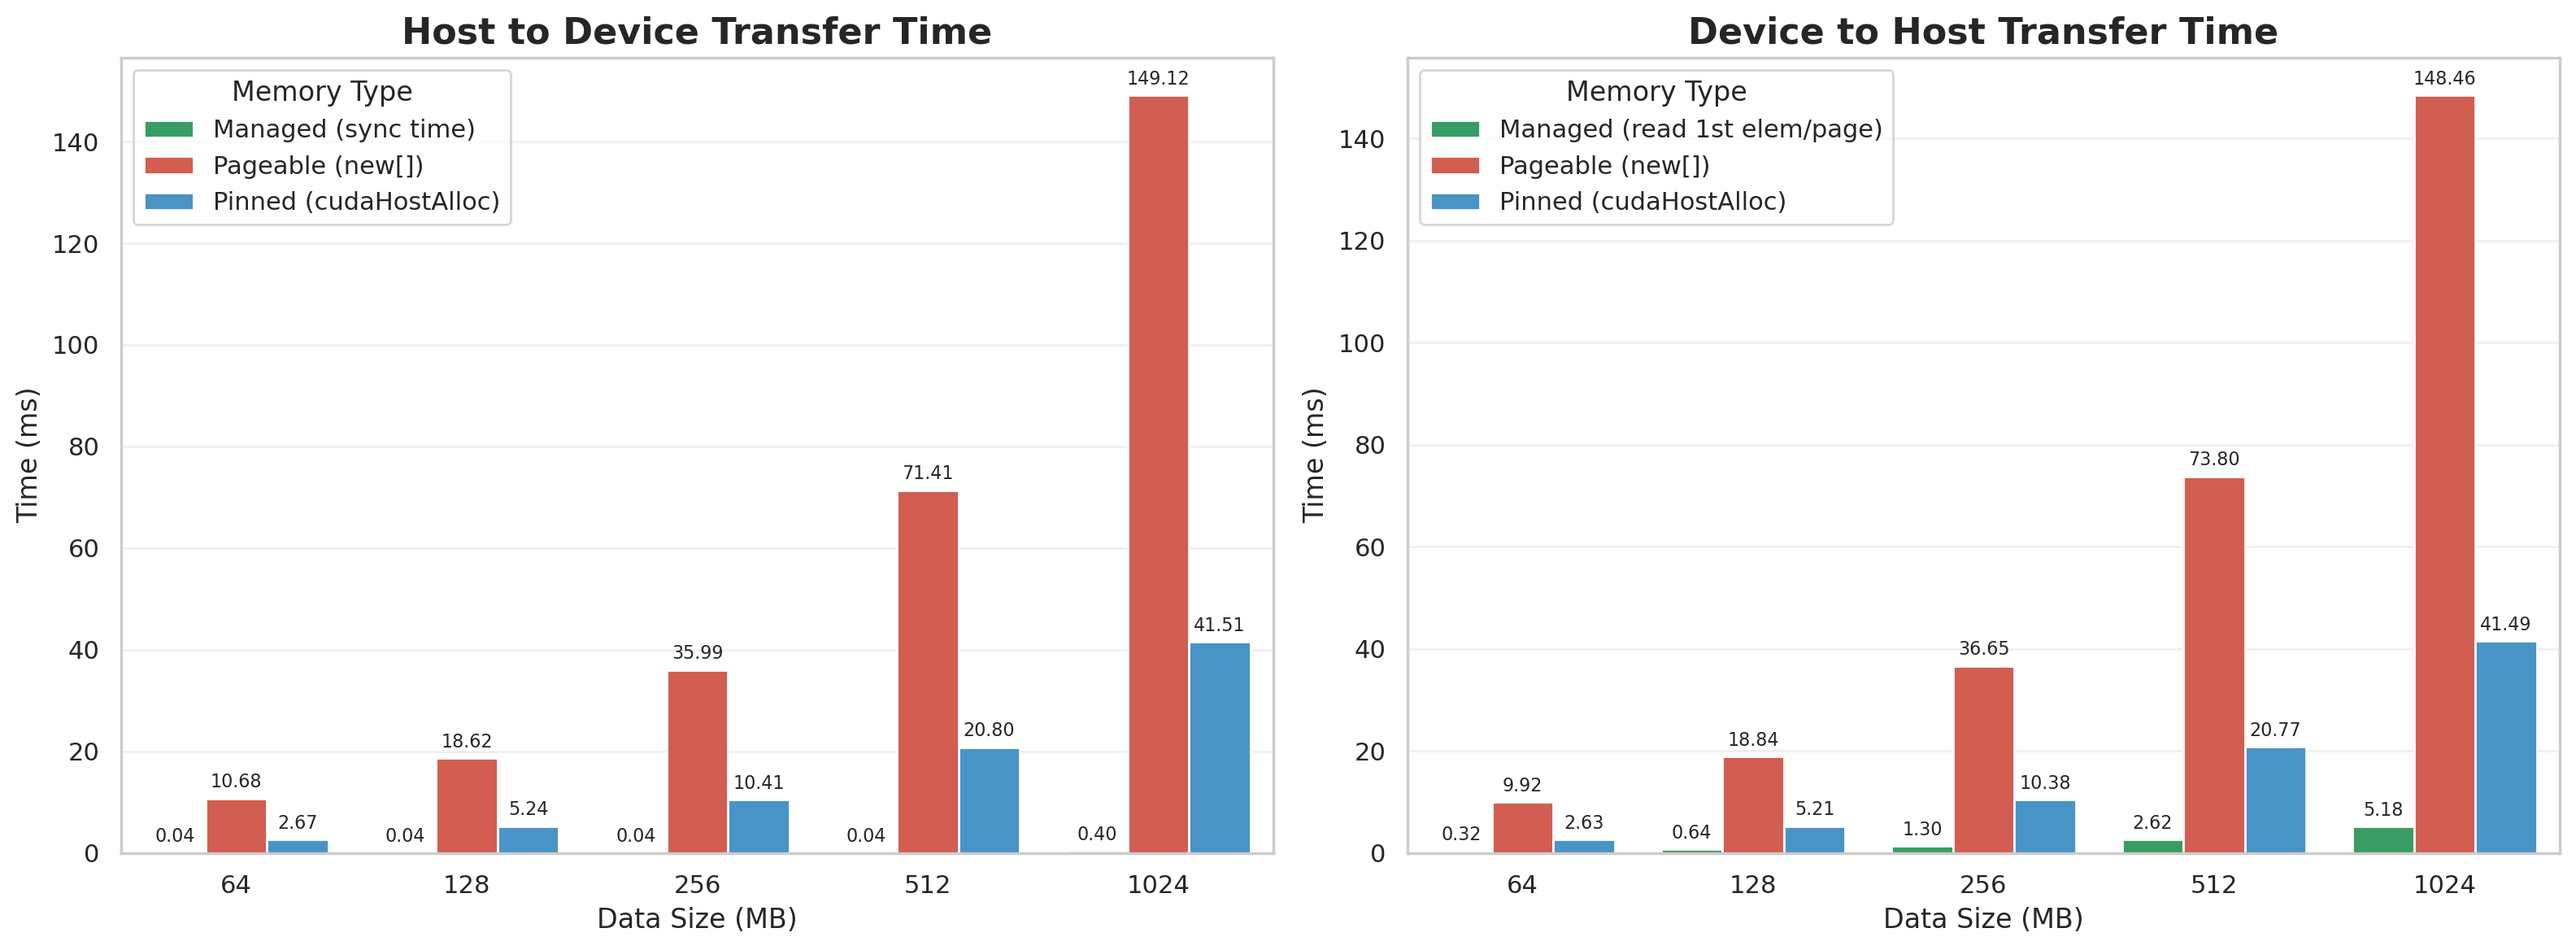

In [26]:
# Combined H2D and D2H Transfer Time Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=200)

# Plot 1: Host to Device Transfer Time
sns.barplot(data=df, x='size_mb', y='h2d_ms', hue='memory_type', 
            palette={'Pageable': '#e74c3c', 'Pinned': '#3498db', 'Managed': '#27ae60'}, ax=ax1)

ax1.set_title('Host to Device Transfer Time', fontsize=16, fontweight='bold')
ax1.set_ylabel('Time (ms)', fontsize=12)
ax1.set_xlabel('Data Size (MB)', fontsize=12)

# Update legend labels
handles, labels = ax1.get_legend_handles_labels()
label_map = {
    'Pageable': 'Pageable (new[])',
    'Pinned': 'Pinned (cudaHostAlloc)',
    'Managed': 'Managed (sync time)'
}
labels = [label_map.get(label, label) for label in labels]
ax1.legend(handles, labels, title='Memory Type', loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

# Plot 2: Device to Host Transfer Time
sns.barplot(data=df, x='size_mb', y='d2h_ms', hue='memory_type', 
            palette={'Pageable': '#e74c3c', 'Pinned': '#3498db', 'Managed': '#27ae60'}, ax=ax2)

ax2.set_title('Device to Host Transfer Time', fontsize=16, fontweight='bold')
ax2.set_ylabel('Time (ms)', fontsize=12)
ax2.set_xlabel('Data Size (MB)', fontsize=12)

# Update legend labels
handles, labels = ax2.get_legend_handles_labels()
label_map = {
    'Pageable': 'Pageable (new[])',
    'Pinned': 'Pinned (cudaHostAlloc)',
    'Managed': 'Managed (read 1st elem/page)'
}
labels = [label_map.get(label, label) for label in labels]
ax2.legend(handles, labels, title='Memory Type', loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

plt.tight_layout()
plt.show()

# Compare memory layout: separate vs. combined

# Memory Layout Comparison (Separate vs Combined)

Comparing separate arrays (A, B, C, D) vs combined interleaved memory layout.

In [27]:
# Compile compare_mem_layout
print("Compiling compare_mem_layout...")
result = subprocess.run(['make', 'compare_mem_layout'],
                       cwd='./',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

Compiling compare_mem_layout...
✓ Compilation successful
✓ Compilation successful


In [28]:
# Run memory layout benchmarks
test_configs = [(100000, 64), (200000, 64), (1000000, 64), (2000000, 64)]
csv_file_layout = './compare_mem_layout_output.csv'
num_runs_layout = 5

# Collect data from each run
all_layout_data = []
for num_matrices, threads in tqdm(test_configs, desc="Test configs", unit="config"):
    for run in tqdm(range(num_runs_layout), desc=f"{num_matrices}×{threads}", leave=False, unit="run"):
        subprocess.run(['./compare_mem_layout', str(num_matrices), str(threads)],
                       cwd='./',
                       capture_output=True)
        # Read CSV after each run and accumulate
        run_df = pd.read_csv(csv_file_layout)
        all_layout_data.append(run_df)

# Combine all runs and calculate averages
raw_layout_df = pd.concat(all_layout_data, ignore_index=True)
layout_df = raw_layout_df.groupby(['num_matrices', 'threads_per_block', 'layout']).mean().reset_index()
print(f"\nCollected {len(raw_layout_df)} measurements, averaged to {len(layout_df)} results")
layout_df

Test configs: 100%|██████████| 4/4 [01:07<00:00, 16.82s/config]


Collected 80 measurements, averaged to 16 results


,num_matrices,threads_per_block,layout,cpu_ms,omp_ms,gpu_ms,gpu_xfer_ms,gpu_total_ms,cpu_gflops,omp_gflops,gpu_gflops,speedup
0,100000,64,Combined (Managed),6.3260,2.5260,1.7580,0.000,1.7580,6.08,16.02,21.84,3.598
1,100000,64,Combined (Pinned),7.5660,2.7180,1.4380,1.394,2.8320,5.08,15.02,26.68,2.670
2,100000,64,Separate (Managed),7.1310,2.7668,9.2568,0.000,9.2568,5.38,14.50,14.56,2.702
3,100000,64,Separate (Pinned),7.1080,2.3620,1.2140,1.512,2.7260,5.40,16.80,31.64,2.606
4,200000,64,Combined (Managed),12.7280,6.0800,3.0160,0.000,3.0160,6.04,14.16,25.48,4.220
5,200000,64,Combined (Pinned),14.6620,4.9120,2.4360,2.620,5.0560,5.24,16.38,31.50,2.902
6,200000,64,Separate (Managed),14.2460,5.0710,3.3556,0.000,3.3556,5.40,15.66,22.92,4.256
7,200000,64,Separate (Pinned),14.2460,4.6020,2.0080,2.740,4.7520,5.40,17.50,38.22,2.998
8,1000000,64,Combined (Managed),70.8640,19.3360,14.0180,0.000,14.0180,5.42,20.24,27.40,5.056
9,1000000,64,Combined (Pinned),70.8600,18.9240,10.4760,12.504,22.9820,5.40,20.46,36.66,3.084


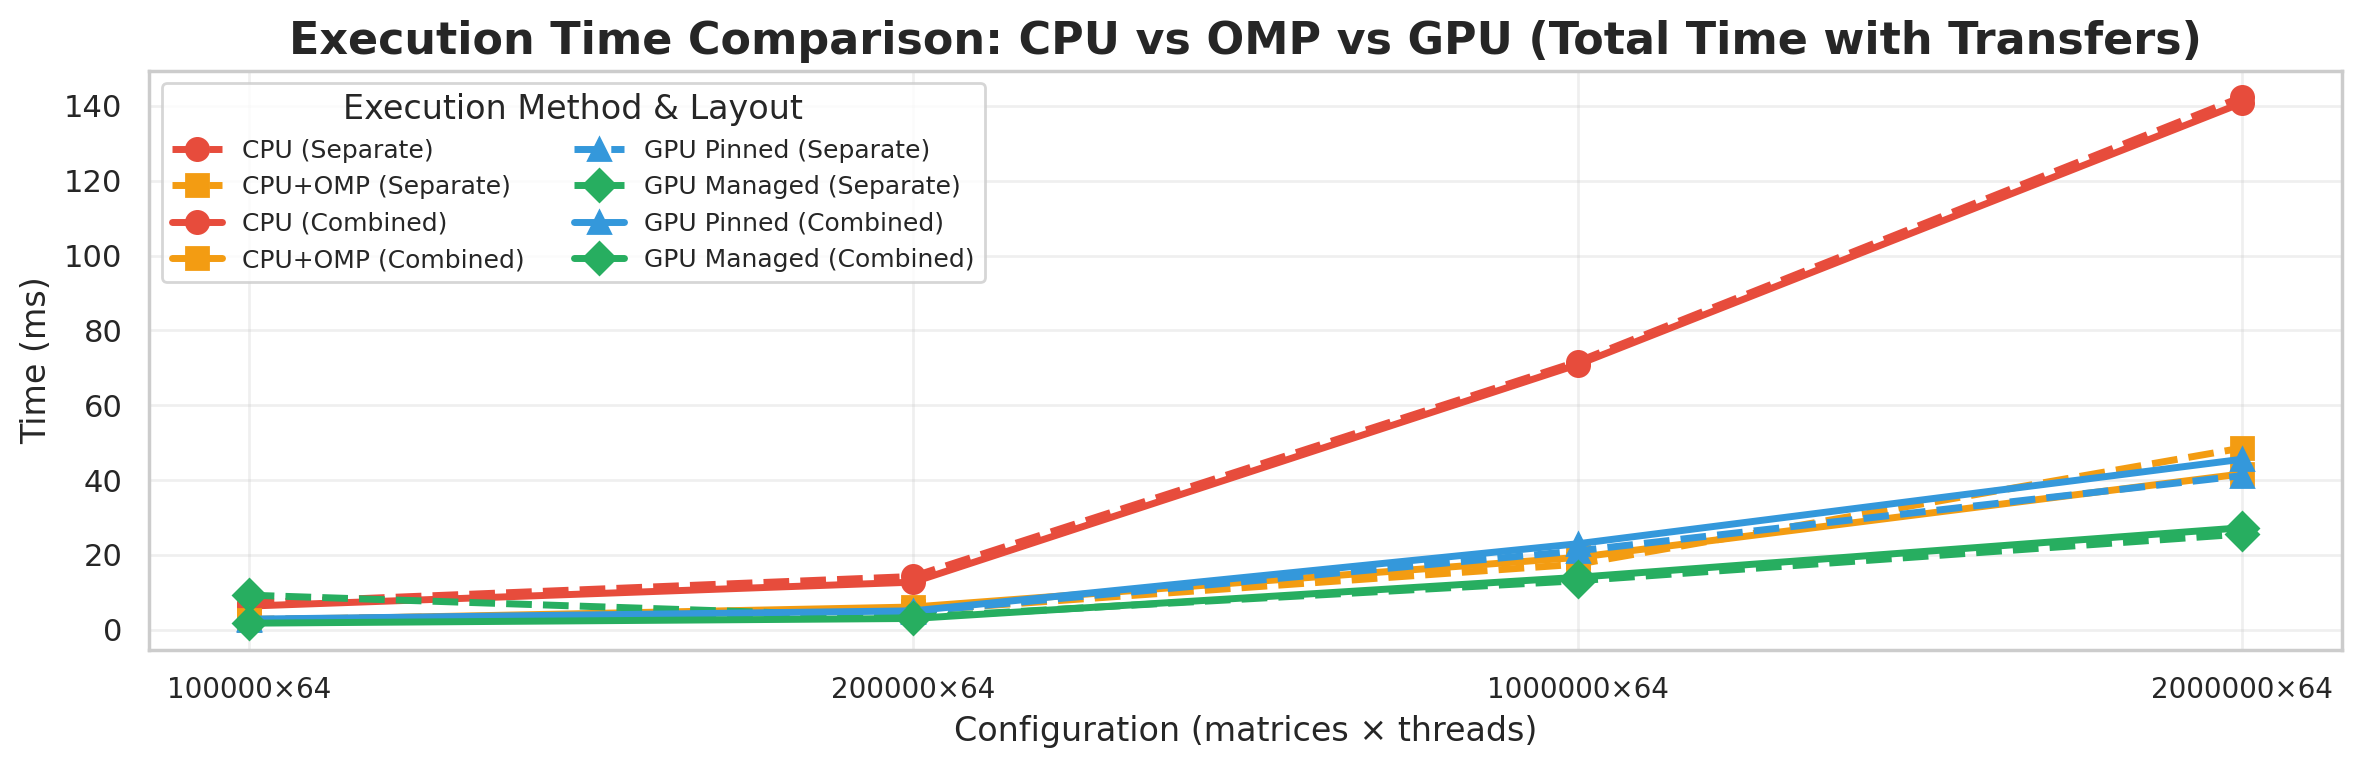

In [29]:
# Execution Time Comparison: Line plot with layout distinction
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Create config column first
layout_df['config'] = layout_df['num_matrices'].astype(str) + '×' + layout_df['threads_per_block'].astype(str)

# Get unique configs and sort by num_matrices
unique_configs = layout_df[['config', 'num_matrices']].drop_duplicates().sort_values('num_matrices')
config_order = unique_configs['config'].tolist()

# Check if we have managed memory data
has_managed = any('Managed' in str(layout) for layout in layout_df['layout'].unique())

# Define colors for different execution methods
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Separate data by layout type
separate_df = layout_df[layout_df['layout'].str.contains('Separate', case=False)]
combined_df = layout_df[layout_df['layout'].str.contains('Combined', case=False)]

# Plot CPU (same for both managed and pinned within same layout)
for layout_type, df, linestyle in [('Separate', separate_df, '--'), ('Combined', combined_df, '-')]:
    if len(df) == 0:
        continue
    
    # Group by config to get unique CPU/OMP values (they're same for managed/pinned)
    df_grouped = df.groupby('config').first().reindex(config_order)
    x_pos = range(len(config_order))
    
    # CPU
    ax.plot(x_pos, df_grouped['cpu_ms'], linestyle=linestyle, linewidth=2.5, 
            marker='o', markersize=8, color=colors['CPU'], 
            label=f'CPU ({layout_type})')
    
    # CPU+OMP
    ax.plot(x_pos, df_grouped['omp_ms'], linestyle=linestyle, linewidth=2.5,
            marker='s', markersize=8, color=colors['CPU+OMP'],
            label=f'CPU+OMP ({layout_type})')

# Plot GPU data - separate lines for Pinned and Managed
for layout_type, df, linestyle in [('Separate', separate_df, '--'), ('Combined', combined_df, '-')]:
    if len(df) == 0:
        continue
    
    # GPU Pinned
    pinned_df = df[df['layout'].str.contains('Pinned', case=False)]
    if len(pinned_df) > 0:
        pinned_grouped = pinned_df.set_index('config').reindex(config_order)
        x_pos = range(len(config_order))
        ax.plot(x_pos, pinned_grouped['gpu_total_ms'], linestyle=linestyle, linewidth=2.5,
                marker='^', markersize=8, color=colors['GPU (Pinned)'],
                label=f'GPU Pinned ({layout_type})')
    
    # GPU Managed (only if available)
    if has_managed:
        managed_df = df[df['layout'].str.contains('Managed', case=False)]
        if len(managed_df) > 0:
            managed_grouped = managed_df.set_index('config').reindex(config_order)
            ax.plot(x_pos, managed_grouped['gpu_total_ms'], linestyle=linestyle, linewidth=2.5,
                    marker='D', markersize=8, color=colors['GPU (Managed)'],
                    label=f'GPU Managed ({layout_type})')

plt.title('Execution Time Comparison: CPU vs OMP vs GPU (Total Time with Transfers)', 
          fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Configuration (matrices × threads)', fontsize=12)
ax.set_xticks(range(len(config_order)))
ax.set_xticklabels(config_order, fontsize=10)
ax.legend(title='Execution Method & Layout', loc='best', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare variable joints

# Variable Joints Benchmark Analysis

Analyzing the performance impact of chain length (number of joints) on matrix multiplication.

In [8]:
# Compile and run variable joints benchmark
print("Compiling compare_variable_joints...")
result = subprocess.run(['make', 'compare_variable_joints'],
                       cwd='./',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

Compiling compare_variable_joints...
✓ Compilation successful


In [9]:
# Run variable joints benchmark with multiple runs and averaging
csv_file_joints = './compare_variable_joints_output.csv'
num_runs_joints = 5

# Collect data from each run
all_joints_data = []
for run in tqdm(range(num_runs_joints), desc="Variable joints runs", unit="run"):
    subprocess.run(['./compare_variable_joints', '500000', '64'],
                   cwd='./',
                   capture_output=True)
    # Read CSV after each run and accumulate
    run_df = pd.read_csv(csv_file_joints)
    all_joints_data.append(run_df)


Variable joints runs: 100%|██████████| 5/5 [07:50<00:00, 94.07s/run]


In [10]:

# Combine all runs and calculate averages
raw_joints_df = pd.concat(all_joints_data, ignore_index=True)
averaged_df = raw_joints_df.groupby('num_joints').mean().reset_index()

# Reshape data to have separate rows for Pinned and Managed memory types
pinned_records = []
managed_records = []

for _, row in averaged_df.iterrows():
    # Pinned memory row
    pinned_records.append({
        'num_joints': row['num_joints'],
        'memory_type': 'Pinned',
        'cpu_ms': row['cpu_ms'],
        'omp_ms': row['omp_ms'],
        'gpu_kernel_ms': row['gpu_pinned_kernel_ms'],
        'transfer_ms': row['gpu_pinned_xfer_ms'],
        'total_ms': row['gpu_pinned_total_ms'],
        'cpu_gflops': row['cpu_gflops'],
        'omp_gflops': row['omp_gflops'],
        'gpu_gflops': row['gpu_pinned_gflops'],
        'speedup': row['speedup'],
        'cpu_power_w': row['cpu_power_w'],
        'omp_power_w': row['omp_power_w'],
        'gpu_power_w': row['gpu_pinned_power_w']
    })
    
    # Managed memory row (check if columns exist and have valid data)
    if 'gpu_managed_kernel_ms' in row and pd.notna(row['gpu_managed_kernel_ms']):
        managed_records.append({
            'num_joints': row['num_joints'],
            'memory_type': 'Managed',
            'cpu_ms': row['cpu_ms'],
            'omp_ms': row['omp_ms'],
            'gpu_kernel_ms': row['gpu_managed_kernel_ms'],
            'transfer_ms': row['gpu_managed_xfer_ms'],
            'total_ms': row['gpu_managed_total_ms'],
            'cpu_gflops': row['cpu_gflops'],
            'omp_gflops': row['omp_gflops'],
            'gpu_gflops': row['gpu_managed_gflops'],
            'speedup': row['cpu_ms'] / row['gpu_managed_total_ms'],  # Recalculate for managed
            'cpu_power_w': row['cpu_power_w'],
            'omp_power_w': row['omp_power_w'],
            'gpu_power_w': row['gpu_managed_power_w']
        })

# Combine pinned and managed data
joints_df = pd.DataFrame(pinned_records + managed_records)

print(f"\nCollected {len(raw_joints_df)} measurements")
print(f"Averaged to {len(averaged_df)} unique joint configurations")
print(f"Reshaped to {len(joints_df)} rows (Pinned + Managed)")
joints_df


Collected 80 measurements
Averaged to 16 unique joint configurations
Reshaped to 32 rows (Pinned + Managed)


,num_joints,memory_type,cpu_ms,omp_ms,gpu_kernel_ms,transfer_ms,total_ms,cpu_gflops,omp_gflops,gpu_gflops,speedup,cpu_power_w,omp_power_w,gpu_power_w
0,2.0,Pinned,18.6972,12.6704,4.331475,3.815546,8.147021,3.424044,6.127251,14.788366,2.295773,7.109396,6.884479,6.544149
1,4.0,Pinned,37.4908,13.5188,5.402099,6.282342,11.684442,5.130854,14.768228,35.541930,3.208425,6.904049,6.589363,6.583009
2,6.0,Pinned,50.9014,16.4124,7.598899,8.760461,16.359360,6.287456,19.549242,42.111452,3.111478,7.037086,6.581190,6.502884
3,8.0,Pinned,71.3174,18.9588,9.731552,11.210138,20.941691,6.288346,24.706149,46.035826,3.405531,7.186336,6.576704,6.551683
4,10.0,Pinned,88.3160,24.7954,11.938189,13.679737,25.617926,6.522098,23.374574,48.248528,3.447428,7.186144,6.572383,6.573207
5,12.0,Pinned,107.0914,28.5144,14.112333,16.160263,30.272596,6.573850,24.738973,49.885455,3.537576,7.307945,6.613380,6.714130
6,14.0,Pinned,127.4516,32.3070,16.307654,18.624083,34.931738,6.532558,25.756294,51.019002,3.648590,7.216964,6.645844,6.698693
7,16.0,Pinned,150.9532,34.6846,18.509043,21.100109,39.609152,6.364109,27.920553,51.866570,3.811102,7.317136,6.717665,6.823301
8,18.0,Pinned,167.5262,42.5502,20.691335,23.560665,44.252000,6.500574,25.585336,52.582399,3.785719,7.296531,6.821573,6.732198
9,20.0,Pinned,181.9296,49.6448,22.887885,26.046605,48.934489,6.683944,24.663661,53.128548,3.717820,7.363247,6.705904,6.826649


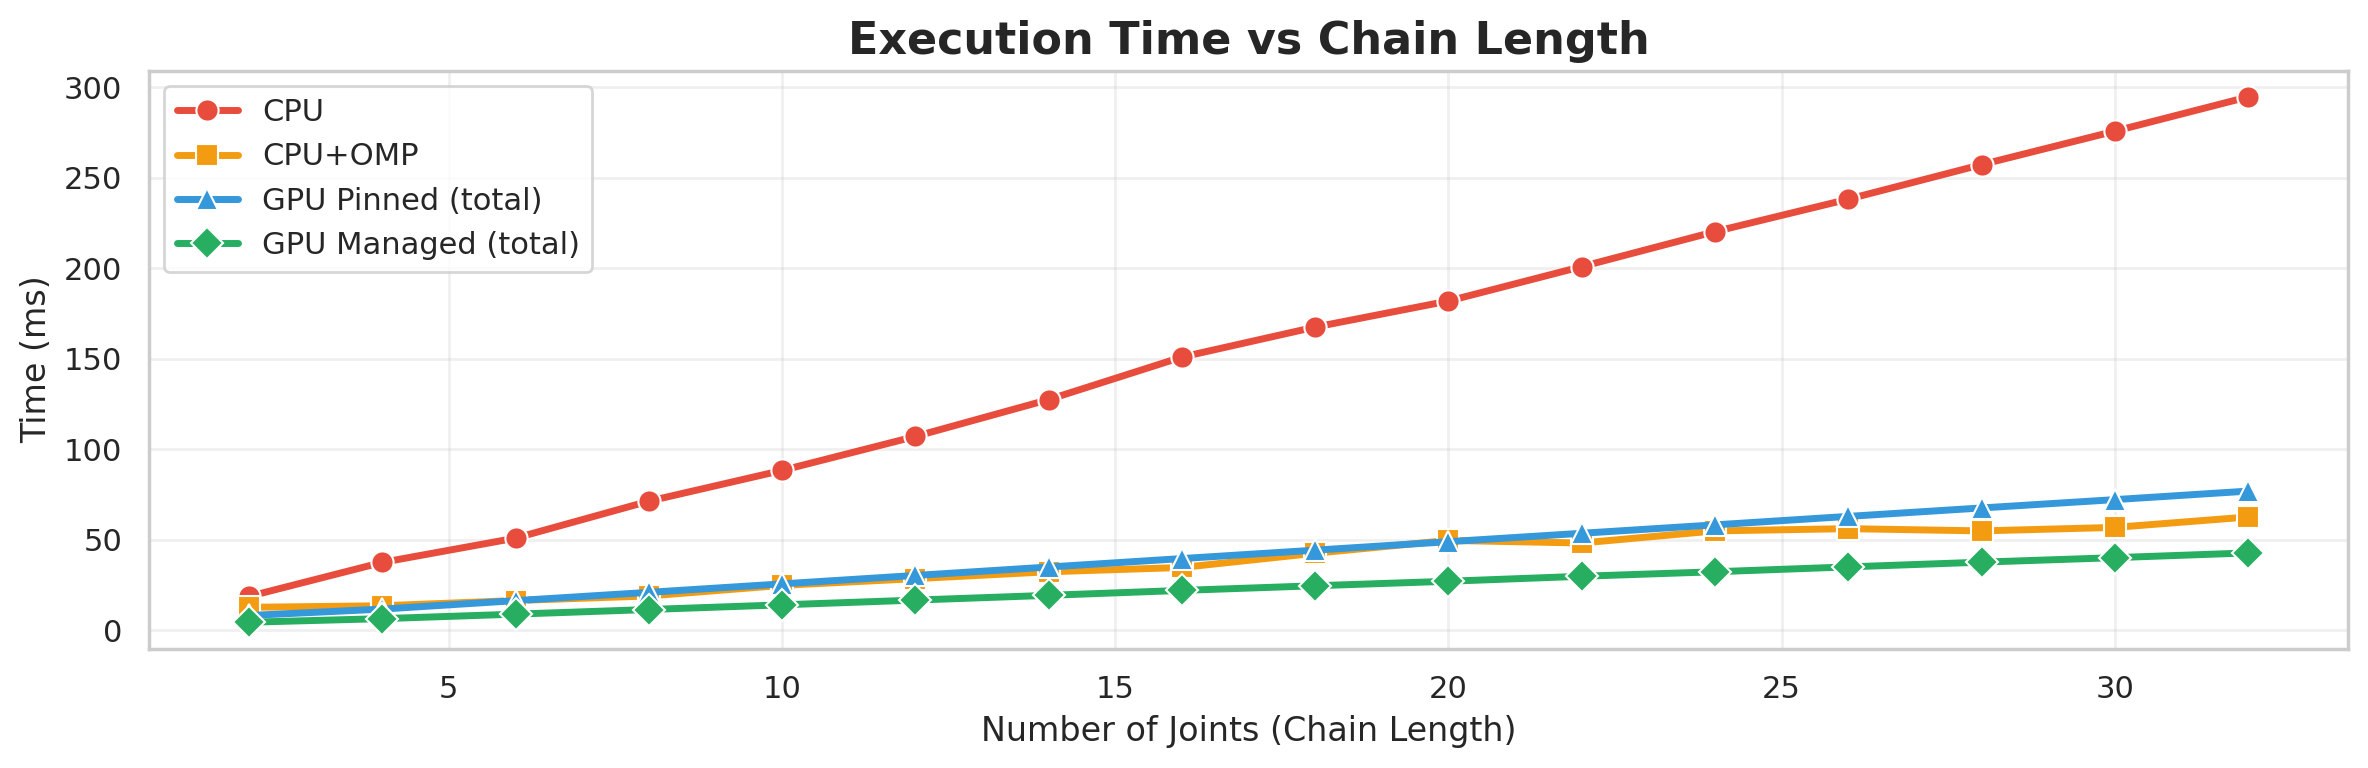

In [11]:
# Execution time vs chain length
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Get CPU/OMP data (same for both memory types, so just take first occurrence per num_joints)
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()

# Plot CPU and CPU+OMP (same regardless of memory type)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_ms', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_ms', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)

# Plot GPU Pinned (always present)
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='total_ms', marker='^', linewidth=2.5, 
                 markersize=8, label='GPU Pinned (total)', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed (only if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='total_ms', marker='D', linewidth=2.5, 
                     markersize=8, label='GPU Managed (total)', color=colors['GPU (Managed)'], ax=ax)

plt.title('Execution Time vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

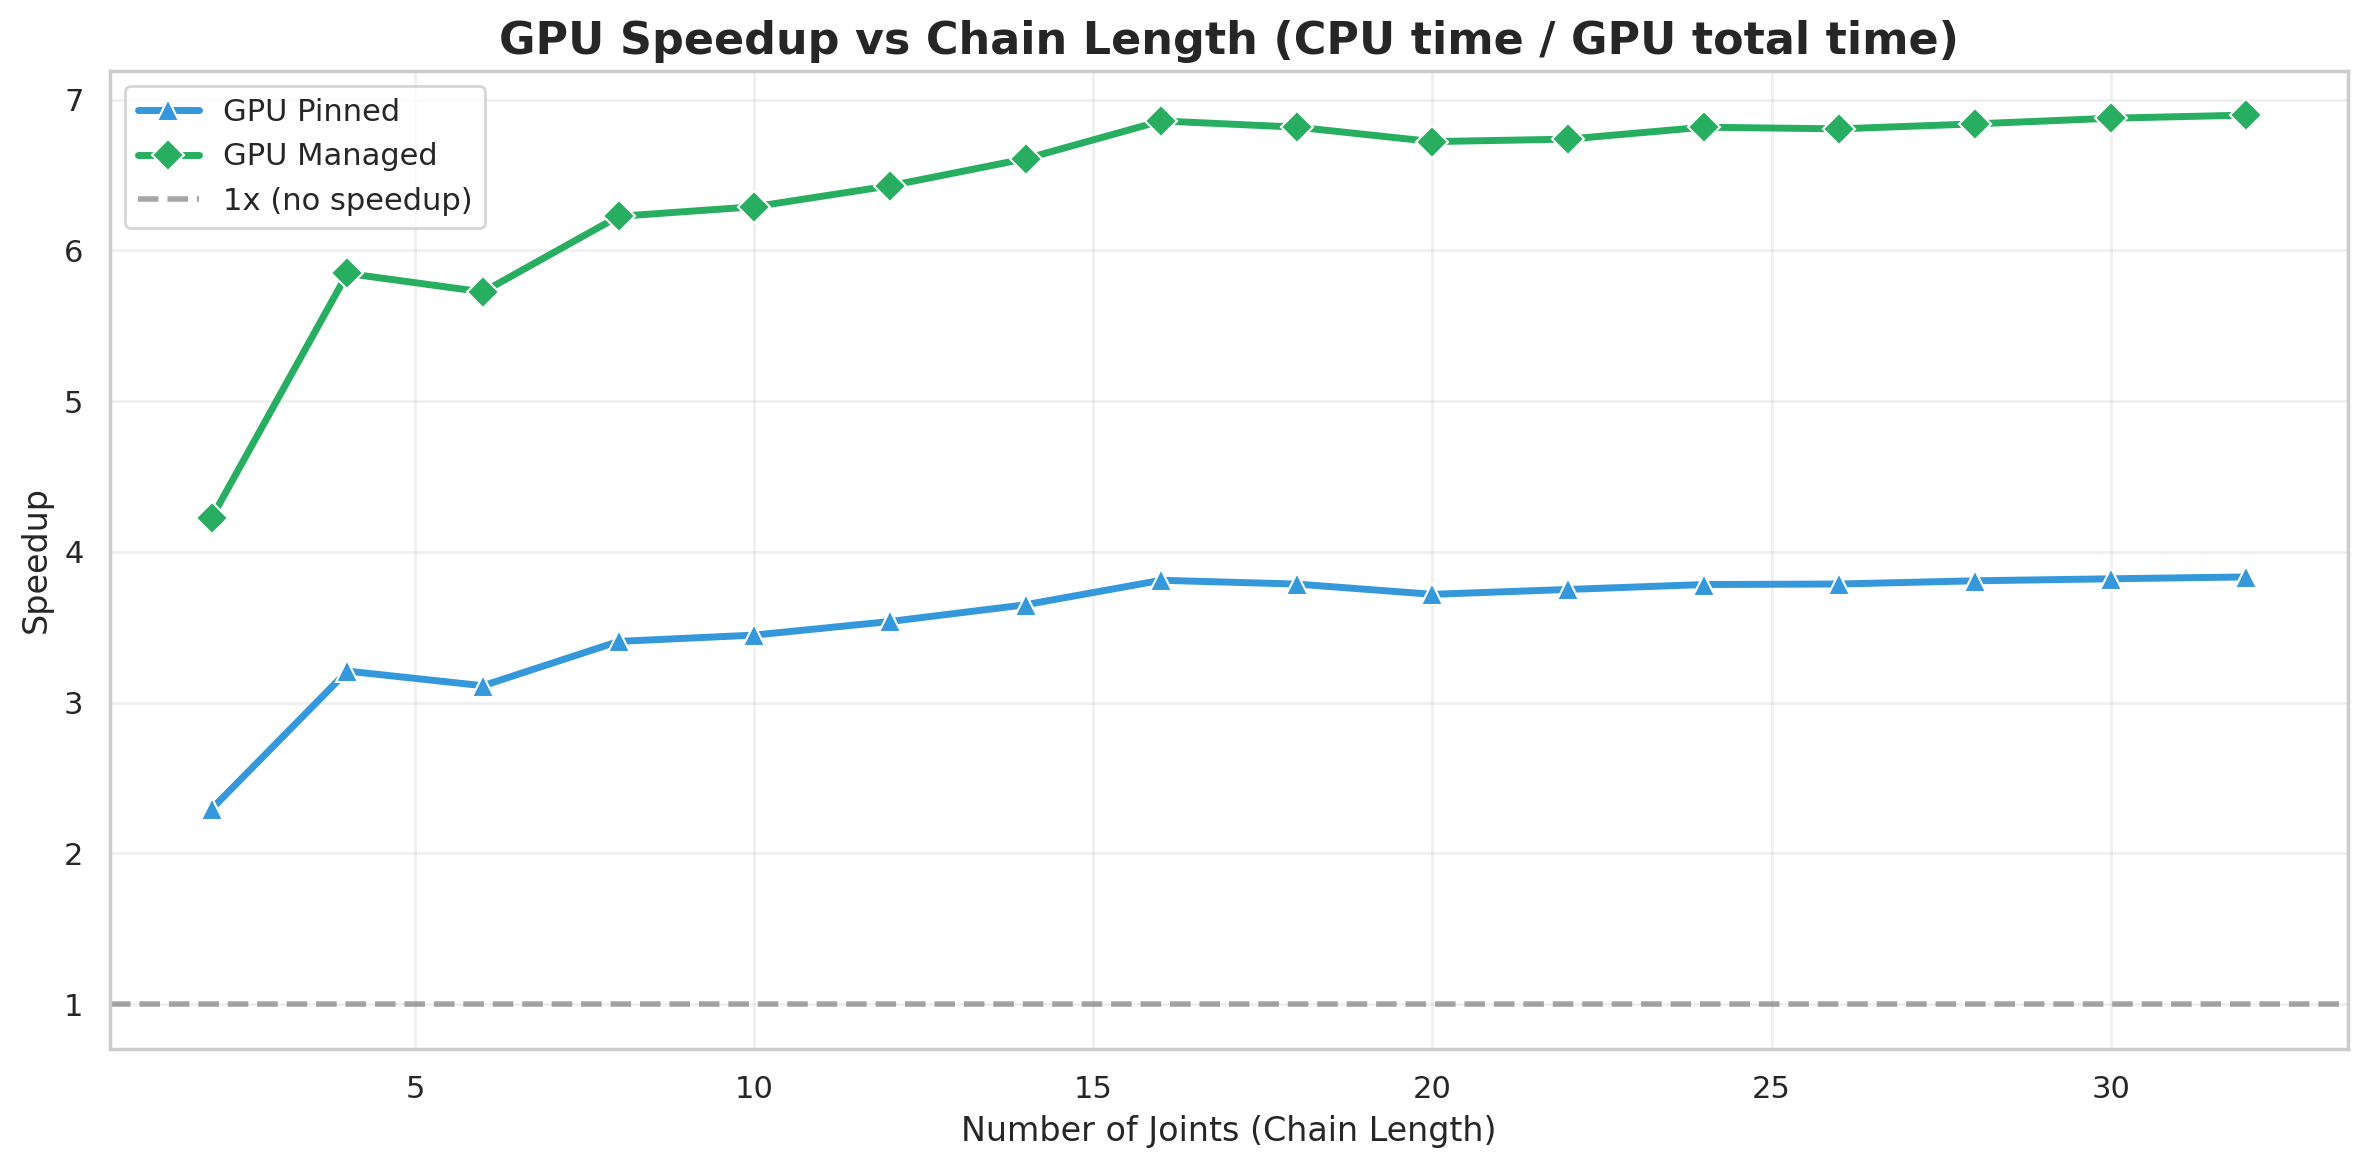

In [12]:
# GPU Speedup vs chain length
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Calculate speedup for each memory type
joints_df['speedup_vs_cpu'] = joints_df['cpu_ms'] / joints_df['total_ms']

# Define colors
colors = {
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Plot GPU Pinned speedup
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='speedup_vs_cpu', marker='^', 
                 linewidth=2.5, markersize=8, color=colors['GPU (Pinned)'], 
                 label='GPU Pinned', ax=ax)

# Plot GPU Managed speedup (only if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='speedup_vs_cpu', marker='D', 
                     linewidth=2.5, markersize=8, color=colors['GPU (Managed)'], 
                     label='GPU Managed', ax=ax)

# Add horizontal line at 1x speedup
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='1x (no speedup)')

plt.title('GPU Speedup vs Chain Length (CPU time / GPU total time)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

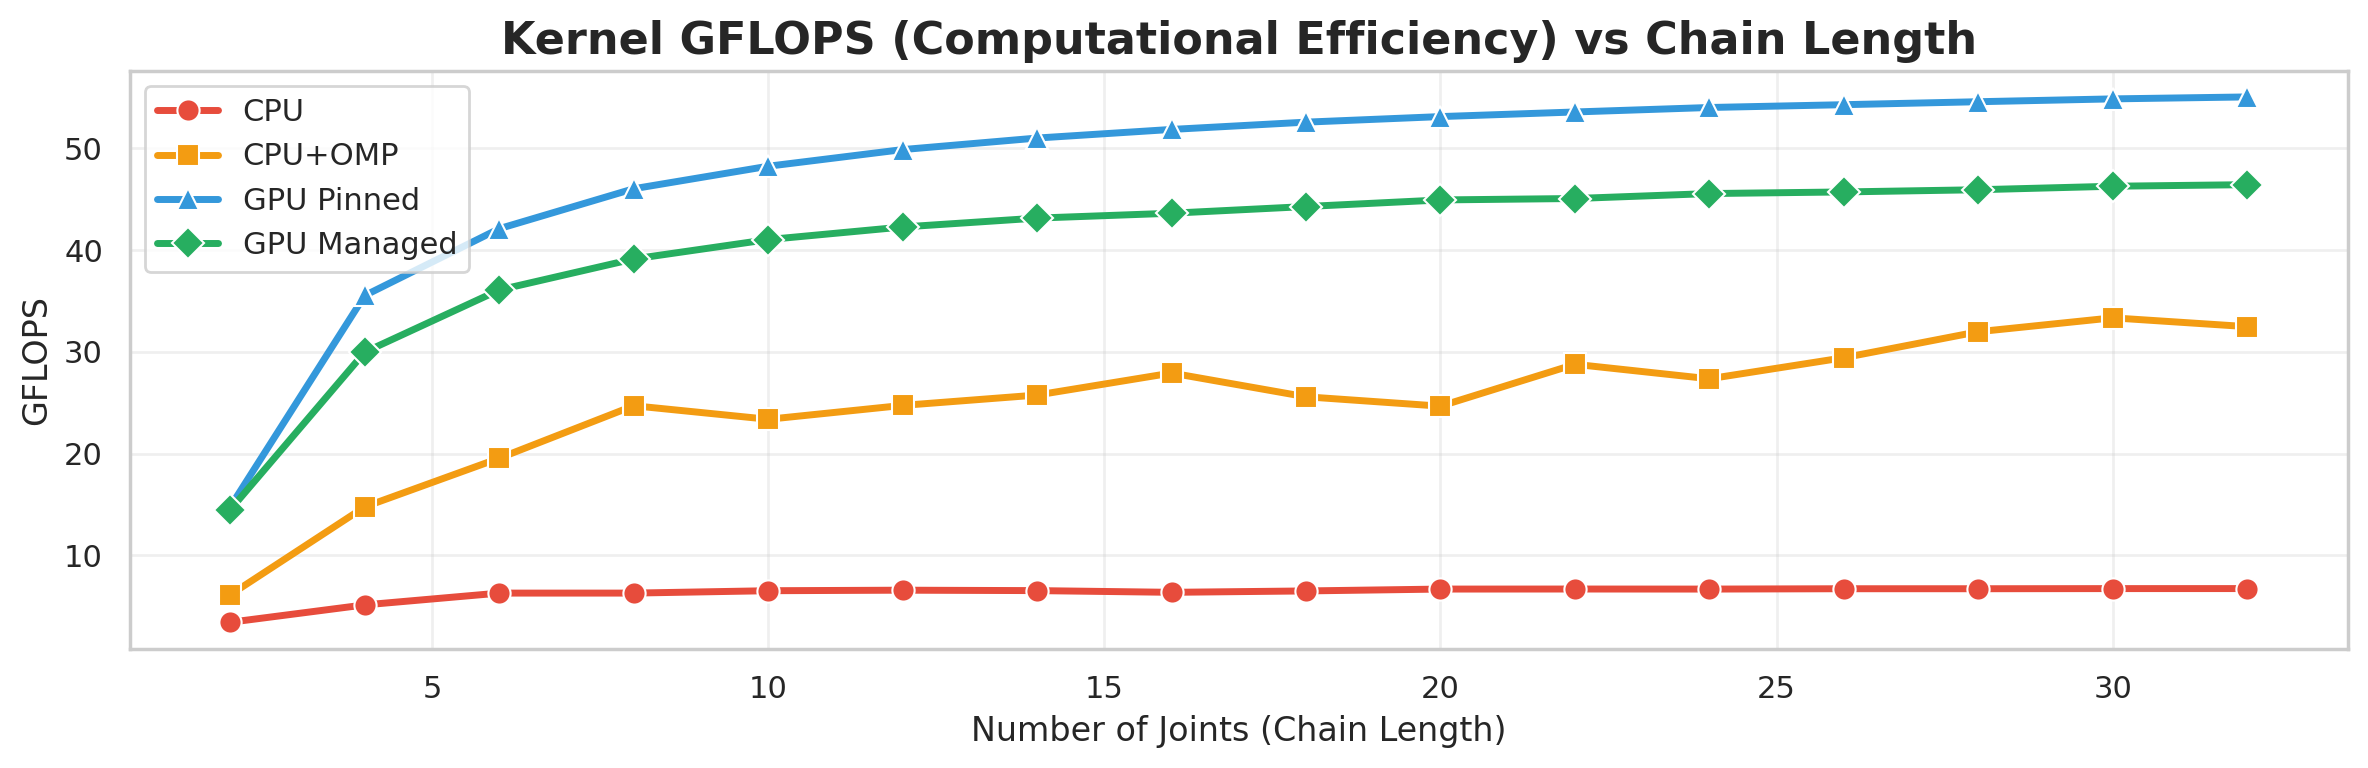

In [ ]:
# GFLOPS comparison showing efficiency
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Get CPU/OMP data (same for both memory types, so just take first occurrence per num_joints)
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()

# Plot CPU and CPU+OMP (same regardless of memory type)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_gflops', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_gflops', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)

# Plot GPU Pinned GFLOPS
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='gpu_gflops', marker='^', linewidth=2.5, 
                 markersize=8, label='GPU Pinned', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed GFLOPS (only if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='gpu_gflops', marker='D', linewidth=2.5, 
                     markersize=8, label='GPU Managed', color=colors['GPU (Managed)'], ax=ax)

plt.title('Kernel GFLOPS (Computational Efficiency) vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('GFLOPS', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

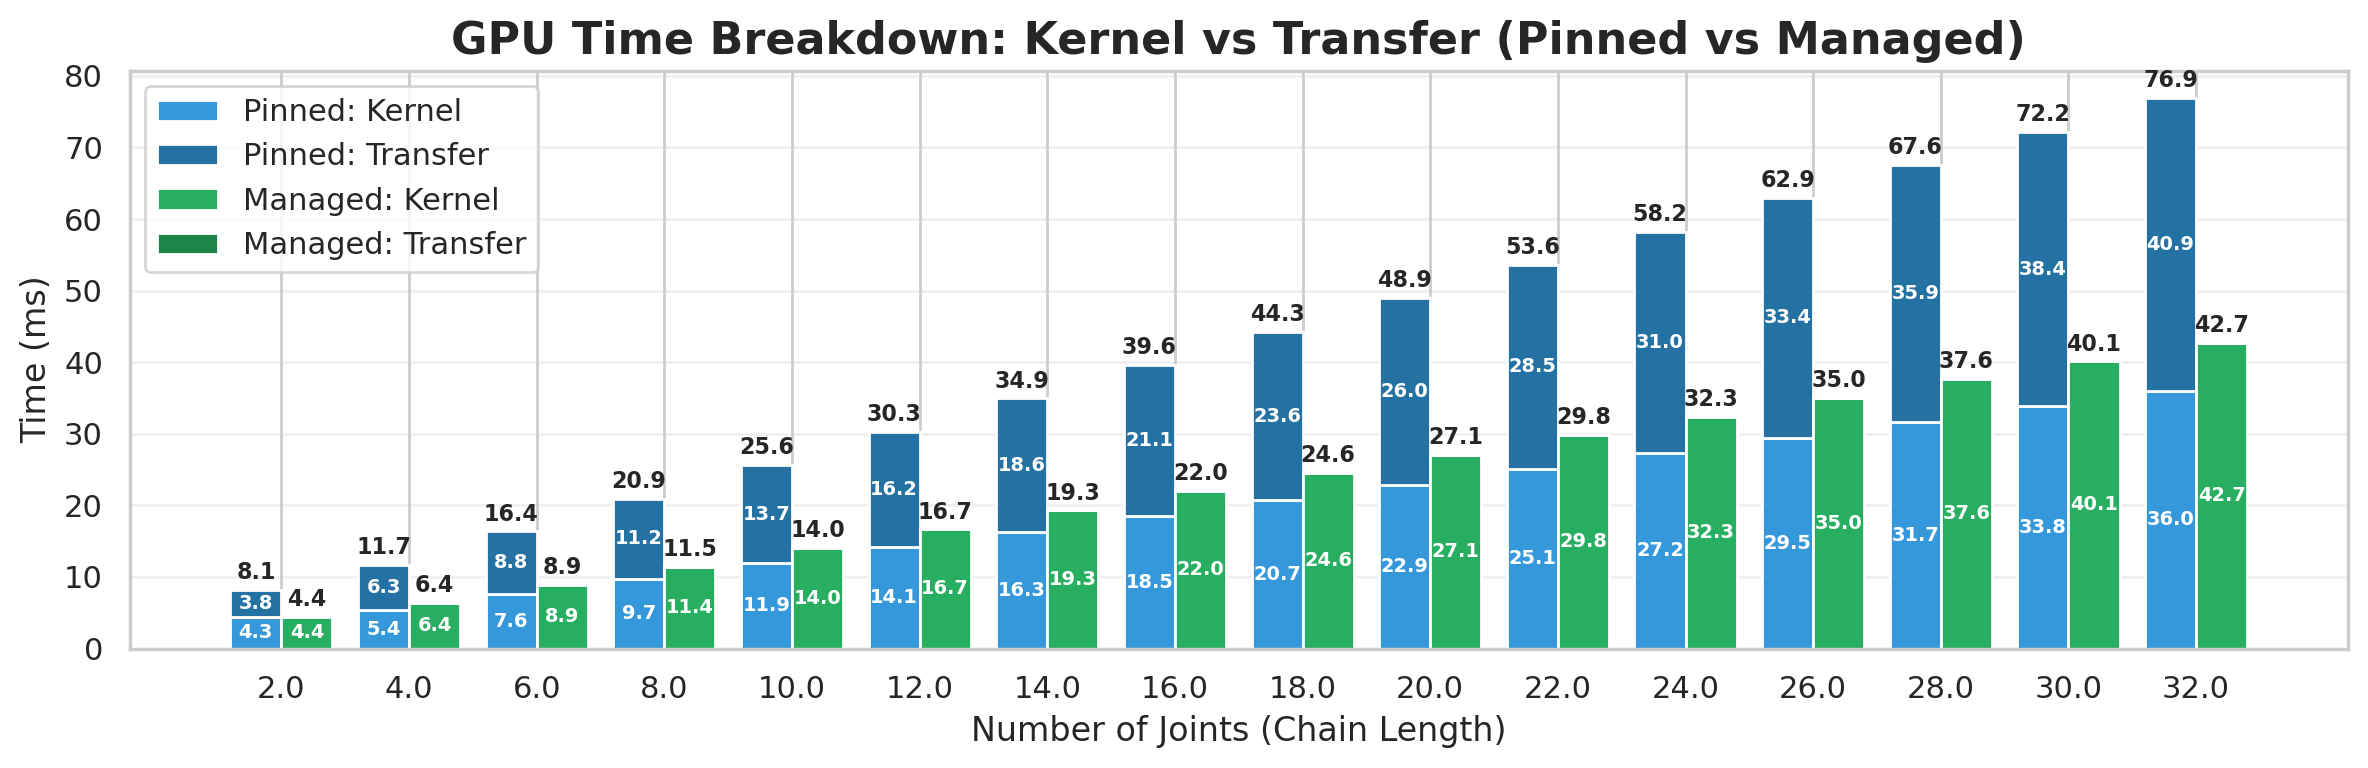

In [ ]:
# Transfer vs kernel time breakdown - Pinned and Managed side by side
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
pinned_kernel_color = '#3498db'
pinned_transfer_color = '#2471a3'
managed_kernel_color = '#27ae60'
managed_transfer_color = '#1e8449'

# Get data
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned'].sort_values('num_joints')
managed_df = joints_df[joints_df['memory_type'] == 'Managed'].sort_values('num_joints') if has_managed else None

# Prepare x positions
num_joints = pinned_df['num_joints'].values
x = np.arange(len(num_joints))
width = 0.4  # Increased from 0.35 to 0.4

# Plot Pinned memory
pinned_kernel = pinned_df['gpu_kernel_ms'].values
pinned_transfer = pinned_df['transfer_ms'].values

ax.bar(x - width/2, pinned_kernel, width, label='Pinned: Kernel', color=pinned_kernel_color)
ax.bar(x - width/2, pinned_transfer, width, bottom=pinned_kernel, label='Pinned: Transfer', color=pinned_transfer_color)

# Add labels for Pinned bars
for i, (k_time, t_time) in enumerate(zip(pinned_kernel, pinned_transfer)):
    total = k_time + t_time
    if k_time > 0.5:
        ax.text(i - width/2, k_time / 2, f'{k_time:.1f}', ha='center', va='center', 
               fontsize=7, fontweight='bold', color='w')
    if t_time > 0.5:
        ax.text(i - width/2, k_time + t_time / 2, f'{t_time:.1f}', ha='center', va='center', 
               fontsize=7, fontweight='bold', color='w')
    ax.text(i - width/2, total + 1.5, f'{total:.1f}', ha='center', fontsize=8, fontweight='bold')

# Plot Managed memory (if available)
if has_managed and managed_df is not None and len(managed_df) > 0:
    managed_kernel = managed_df['gpu_kernel_ms'].values
    managed_transfer = managed_df['transfer_ms'].values
    
    ax.bar(x + width/2, managed_kernel, width, label='Managed: Kernel', color=managed_kernel_color)
    ax.bar(x + width/2, managed_transfer, width, bottom=managed_kernel, label='Managed: Transfer', color=managed_transfer_color)
    
    # Add labels for Managed bars
    for i, (k_time, t_time) in enumerate(zip(managed_kernel, managed_transfer)):
        total = k_time + t_time
        if k_time > 0.5:
            ax.text(i + width/2, k_time / 2, f'{k_time:.1f}', ha='center', va='center', 
                   fontsize=7, fontweight='bold', color='w')
        if t_time > 0.5:  # Lower threshold since managed transfer is usually 0
            ax.text(i + width/2, k_time + t_time / 2, f'{t_time:.1f}', ha='center', va='center', 
                   fontsize=7, fontweight='bold', color='w')
        ax.text(i + width/2, total + 1.5, f'{total:.1f}', ha='center', fontsize=8, fontweight='bold')

# Formatting
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_title('GPU Time Breakdown: Kernel vs Transfer (Pinned vs Managed)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(num_joints)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Power Consumption Analysis

Analyzing power consumption across different execution methods and chain lengths.

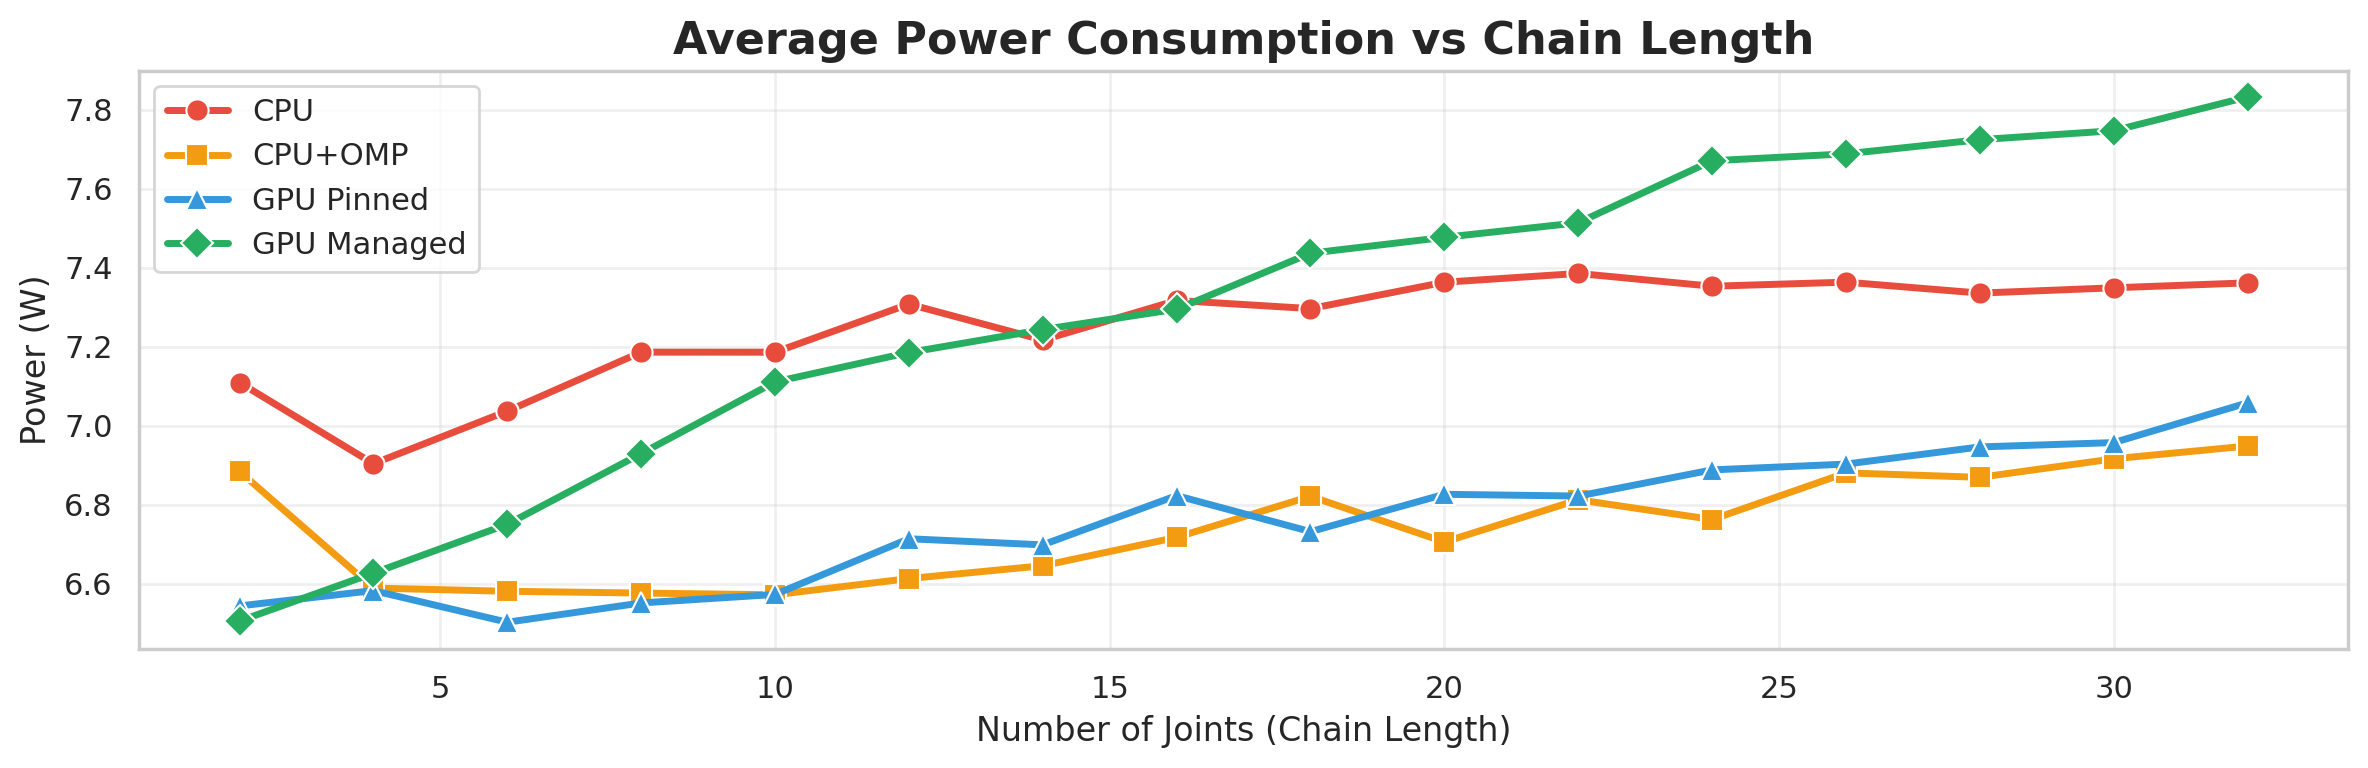

In [ ]:
# Power consumption comparison across execution methods
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Get CPU/OMP data
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()

# Plot power consumption
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_power_w', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_power_w', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)

# Plot GPU Pinned power
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='gpu_power_w', marker='^', linewidth=2.5, 
                 markersize=8, label='GPU Pinned', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed power (if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='gpu_power_w', marker='D', linewidth=2.5, 
                     markersize=8, label='GPU Managed', color=colors['GPU (Managed)'], ax=ax)

plt.title('Average Power Consumption vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Power (W)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

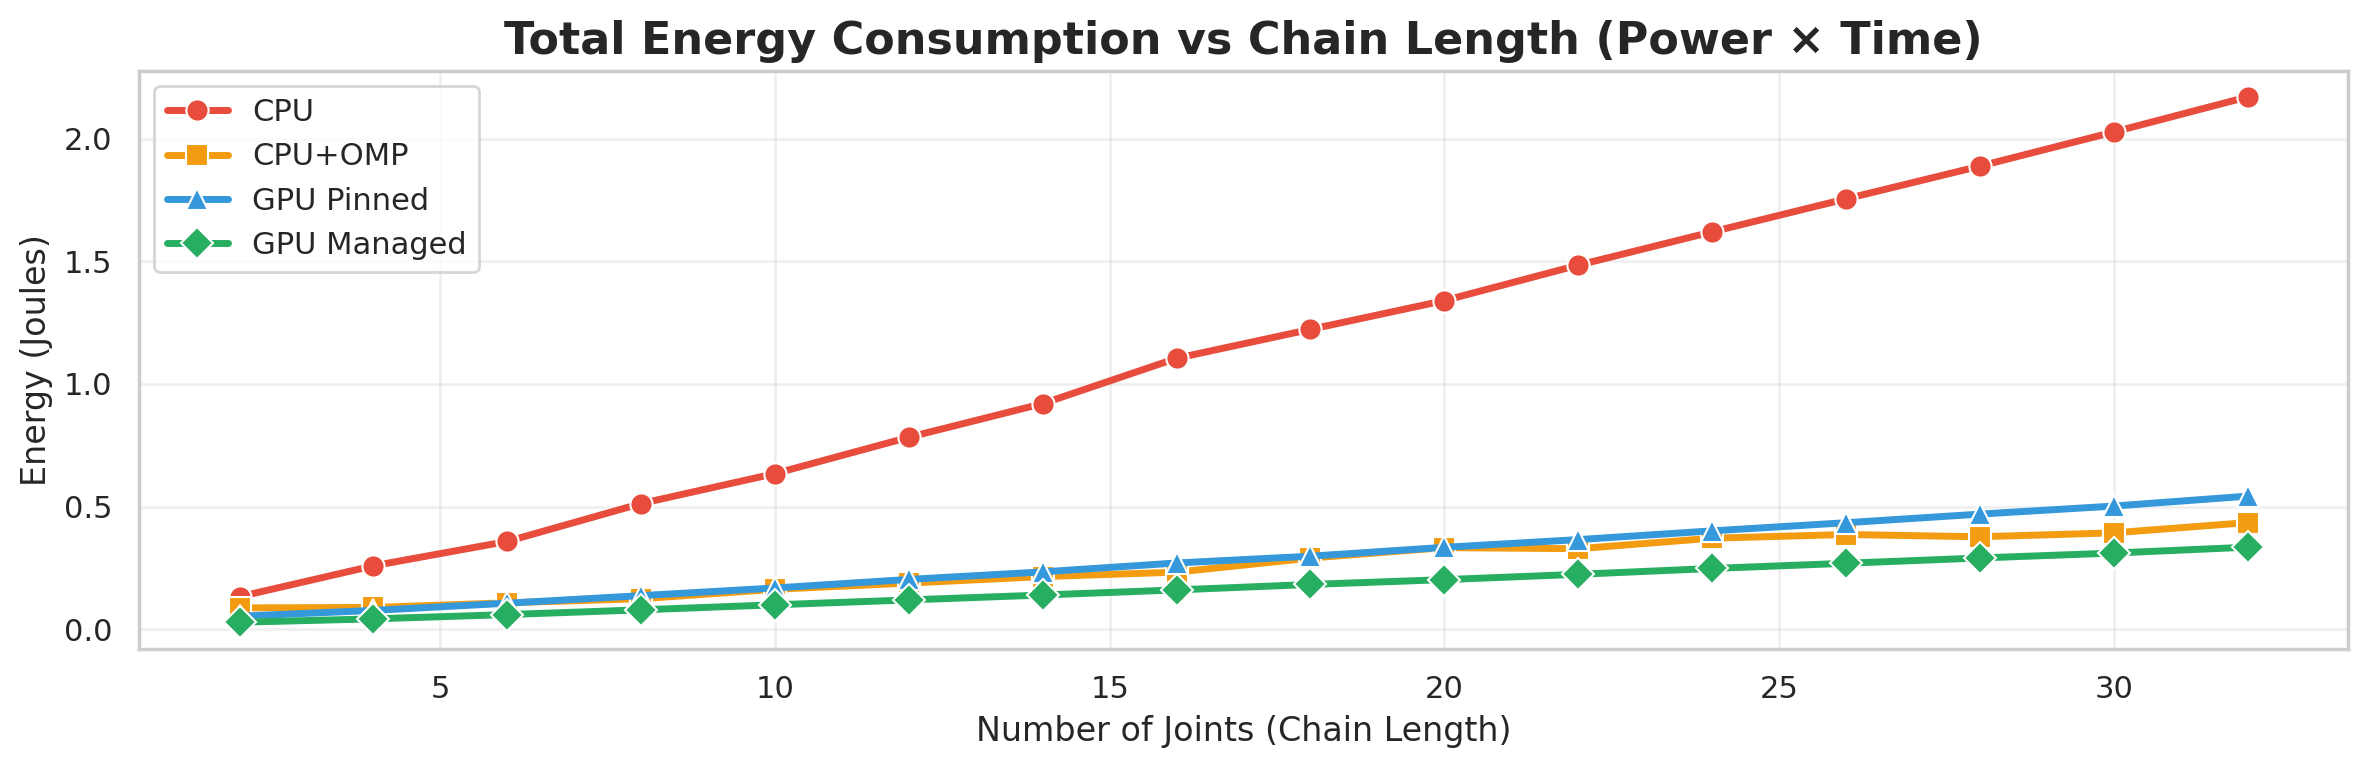

In [ ]:
# Energy consumption (Power × Time)
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Calculate energy in Joules (Watts × seconds)
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()
cpu_omp_df['cpu_energy_j'] = cpu_omp_df['cpu_power_w'] * (cpu_omp_df['cpu_ms'] / 1000.0)
cpu_omp_df['omp_energy_j'] = cpu_omp_df['omp_power_w'] * (cpu_omp_df['omp_ms'] / 1000.0)

pinned_df = joints_df[joints_df['memory_type'] == 'Pinned'].copy()
pinned_df['gpu_energy_j'] = pinned_df['gpu_power_w'] * (pinned_df['total_ms'] / 1000.0)

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Plot energy consumption
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_energy_j', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_energy_j', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)
sns.lineplot(data=pinned_df, x='num_joints', y='gpu_energy_j', marker='^', linewidth=2.5, 
             markersize=8, label='GPU Pinned', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed energy (if available)
if 'Managed' in joints_df['memory_type'].values:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed'].copy()
    managed_df['gpu_energy_j'] = managed_df['gpu_power_w'] * (managed_df['total_ms'] / 1000.0)
    sns.lineplot(data=managed_df, x='num_joints', y='gpu_energy_j', marker='D', linewidth=2.5, 
                 markersize=8, label='GPU Managed', color=colors['GPU (Managed)'], ax=ax)

plt.title('Total Energy Consumption vs Chain Length (Power × Time)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Energy (Joules)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

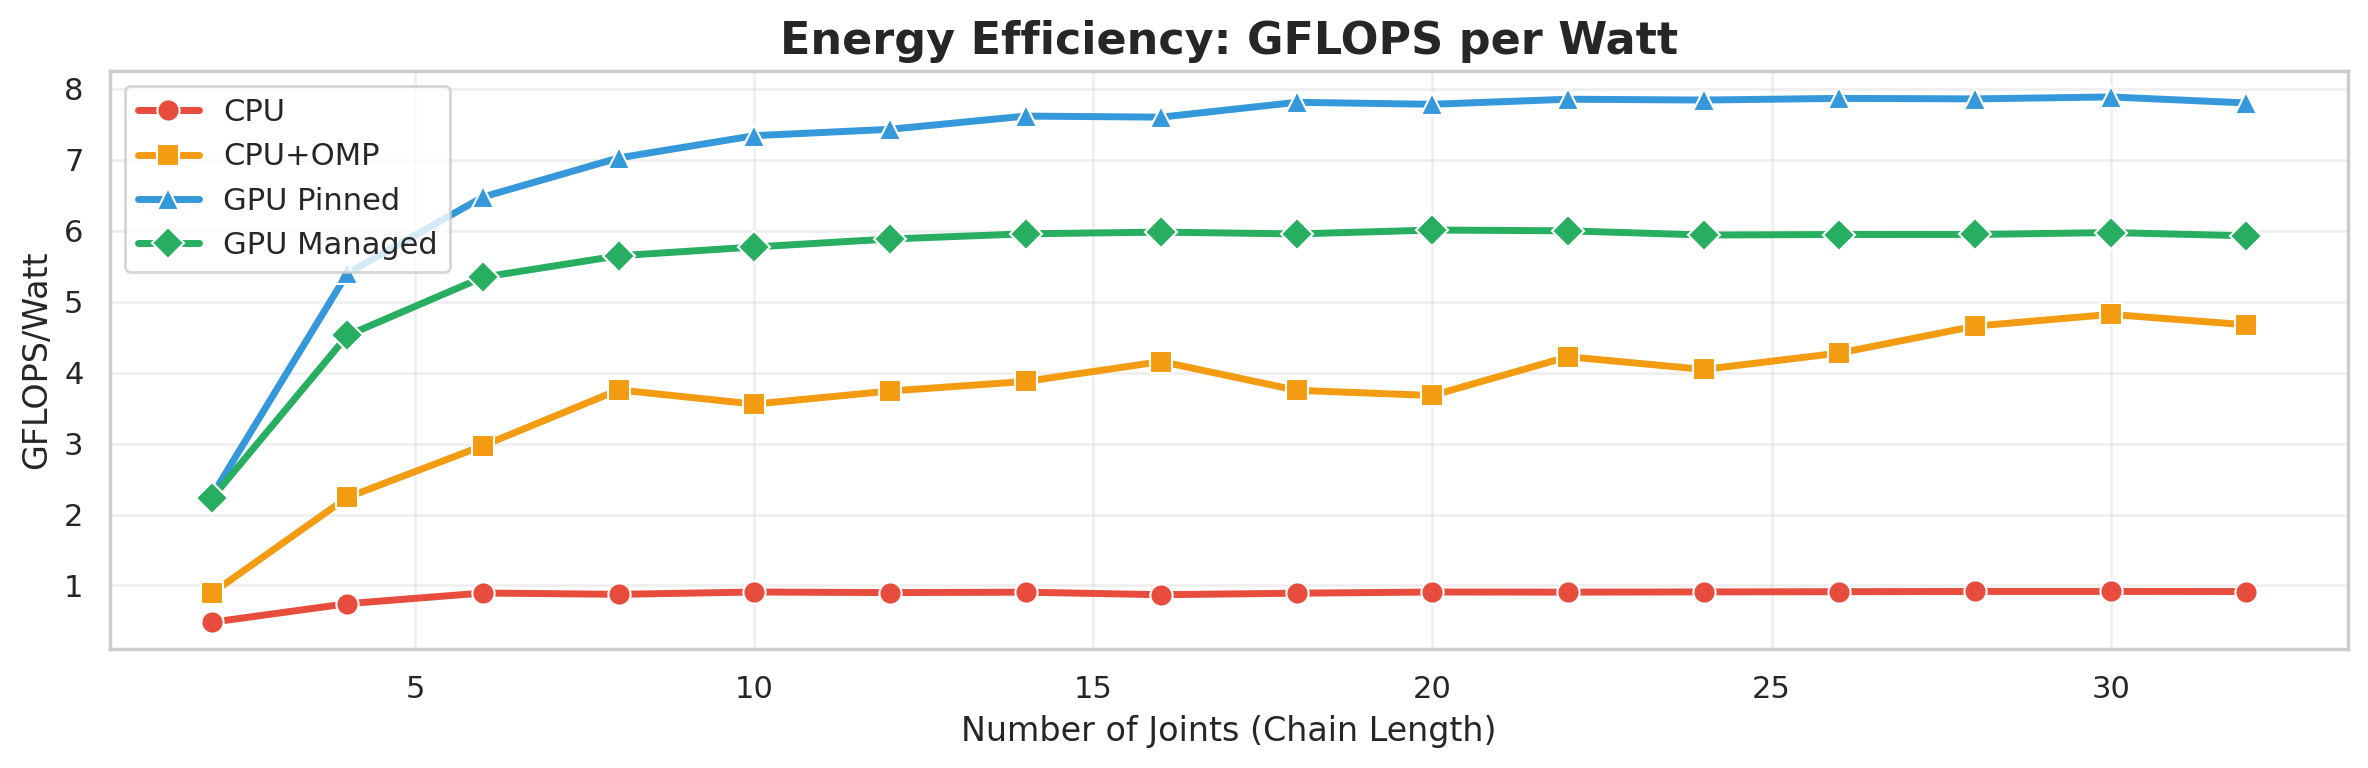

In [ ]:
# Energy efficiency: GFLOPS per Watt
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Calculate GFLOPS/Watt
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()
cpu_omp_df['cpu_gflops_per_watt'] = cpu_omp_df['cpu_gflops'] / cpu_omp_df['cpu_power_w']
cpu_omp_df['omp_gflops_per_watt'] = cpu_omp_df['omp_gflops'] / cpu_omp_df['omp_power_w']

pinned_df = joints_df[joints_df['memory_type'] == 'Pinned'].copy()
pinned_df['gpu_gflops_per_watt'] = pinned_df['gpu_gflops'] / pinned_df['gpu_power_w']

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Plot energy efficiency
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_gflops_per_watt', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_gflops_per_watt', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)
sns.lineplot(data=pinned_df, x='num_joints', y='gpu_gflops_per_watt', marker='^', linewidth=2.5, 
             markersize=8, label='GPU Pinned', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed efficiency (if available)
if 'Managed' in joints_df['memory_type'].values:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed'].copy()
    managed_df['gpu_gflops_per_watt'] = managed_df['gpu_gflops'] / managed_df['gpu_power_w']
    sns.lineplot(data=managed_df, x='num_joints', y='gpu_gflops_per_watt', marker='D', linewidth=2.5, 
                 markersize=8, label='GPU Managed', color=colors['GPU (Managed)'], ax=ax)

plt.title('Energy Efficiency: GFLOPS per Watt', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('GFLOPS/Watt', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Power efficiency comparison table
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned'].copy()

# Calculate metrics for comparison
power_summary = pd.DataFrame({
    'num_joints': cpu_omp_df['num_joints'],
    'CPU_Power_W': cpu_omp_df['cpu_power_w'],
    'OMP_Power_W': cpu_omp_df['omp_power_w'],
    'GPU_Pinned_Power_W': pinned_df['gpu_power_w'].values,
    'CPU_Energy_J': cpu_omp_df['cpu_power_w'] * (cpu_omp_df['cpu_ms'] / 1000.0),
    'OMP_Energy_J': cpu_omp_df['omp_power_w'] * (cpu_omp_df['omp_ms'] / 1000.0),
    'GPU_Pinned_Energy_J': pinned_df['gpu_power_w'].values * (pinned_df['total_ms'].values / 1000.0),
    'CPU_GFLOPS_per_Watt': cpu_omp_df['cpu_gflops'] / cpu_omp_df['cpu_power_w'],
    'OMP_GFLOPS_per_Watt': cpu_omp_df['omp_gflops'] / cpu_omp_df['omp_power_w'],
    'GPU_Pinned_GFLOPS_per_Watt': pinned_df['gpu_gflops'].values / pinned_df['gpu_power_w'].values
})

# Add managed if available
if 'Managed' in joints_df['memory_type'].values:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed'].copy()
    power_summary['GPU_Managed_Power_W'] = managed_df['gpu_power_w'].values
    power_summary['GPU_Managed_Energy_J'] = managed_df['gpu_power_w'].values * (managed_df['total_ms'].values / 1000.0)
    power_summary['GPU_Managed_GFLOPS_per_Watt'] = managed_df['gpu_gflops'].values / managed_df['gpu_power_w'].values

# Display the first few and last few rows
print("Power Efficiency Summary (first 5 and last 5 rows):")
print("\nFirst 5 rows:")
display(power_summary.head().round(3))
print("\nLast 5 rows:")
display(power_summary.tail().round(3))

# Show average values
print("\n" + "="*80)
print("AVERAGE VALUES ACROSS ALL CHAIN LENGTHS:")
print("="*80)
avg_summary = power_summary.drop(columns=['num_joints']).mean().to_frame(name='Average').T
display(avg_summary.round(3))

Power Efficiency Summary (first 5 and last 5 rows):

First 5 rows:


,num_joints,CPU_Power_W,OMP_Power_W,GPU_Pinned_Power_W,CPU_Energy_J,OMP_Energy_J,GPU_Pinned_Energy_J,CPU_GFLOPS_per_Watt,OMP_GFLOPS_per_Watt,GPU_Pinned_GFLOPS_per_Watt,GPU_Managed_Power_W,GPU_Managed_Energy_J,GPU_Managed_GFLOPS_per_Watt
0,2.0,7.109,6.884,6.544,0.133,0.087,0.053,0.482,0.890,2.260,6.506,0.029,2.227
1,4.0,6.904,6.589,6.583,0.259,0.089,0.077,0.743,2.241,5.399,6.627,0.042,4.524
2,6.0,7.037,6.581,6.503,0.358,0.108,0.106,0.893,2.970,6.476,6.751,0.060,5.345
3,8.0,7.186,6.577,6.552,0.513,0.125,0.137,0.875,3.757,7.027,6.929,0.079,5.647
4,10.0,7.186,6.572,6.573,0.635,0.163,0.168,0.908,3.556,7.340,7.111,0.100,5.771



Last 5 rows:


,num_joints,CPU_Power_W,OMP_Power_W,GPU_Pinned_Power_W,CPU_Energy_J,OMP_Energy_J,GPU_Pinned_Energy_J,CPU_GFLOPS_per_Watt,OMP_GFLOPS_per_Watt,GPU_Pinned_GFLOPS_per_Watt,GPU_Managed_Power_W,GPU_Managed_Energy_J,GPU_Managed_GFLOPS_per_Watt
11,24.0,7.353,6.763,6.888,1.620,0.371,0.401,0.909,4.045,7.842,7.671,0.248,5.940
12,26.0,7.363,6.881,6.903,1.754,0.386,0.434,0.912,4.276,7.866,7.688,0.269,5.947
13,28.0,7.336,6.870,6.947,1.887,0.377,0.469,0.916,4.656,7.859,7.724,0.291,5.947
14,30.0,7.349,6.916,6.957,2.027,0.393,0.502,0.916,4.821,7.886,7.747,0.311,5.974
15,32.0,7.362,6.949,7.058,2.170,0.435,0.543,0.915,4.674,7.801,7.832,0.335,5.929



AVERAGE VALUES ACROSS ALL CHAIN LENGTHS:


,CPU_Power_W,OMP_Power_W,GPU_Pinned_Power_W,CPU_Energy_J,OMP_Energy_J,GPU_Pinned_Energy_J,CPU_GFLOPS_per_Watt,OMP_GFLOPS_per_Watt,GPU_Pinned_GFLOPS_per_Watt,GPU_Managed_Power_W,GPU_Managed_Energy_J,GPU_Managed_GFLOPS_per_Watt
Average,7.255,6.744,6.758,1.138,0.258,0.287,0.865,3.707,7.116,7.296,0.175,5.565


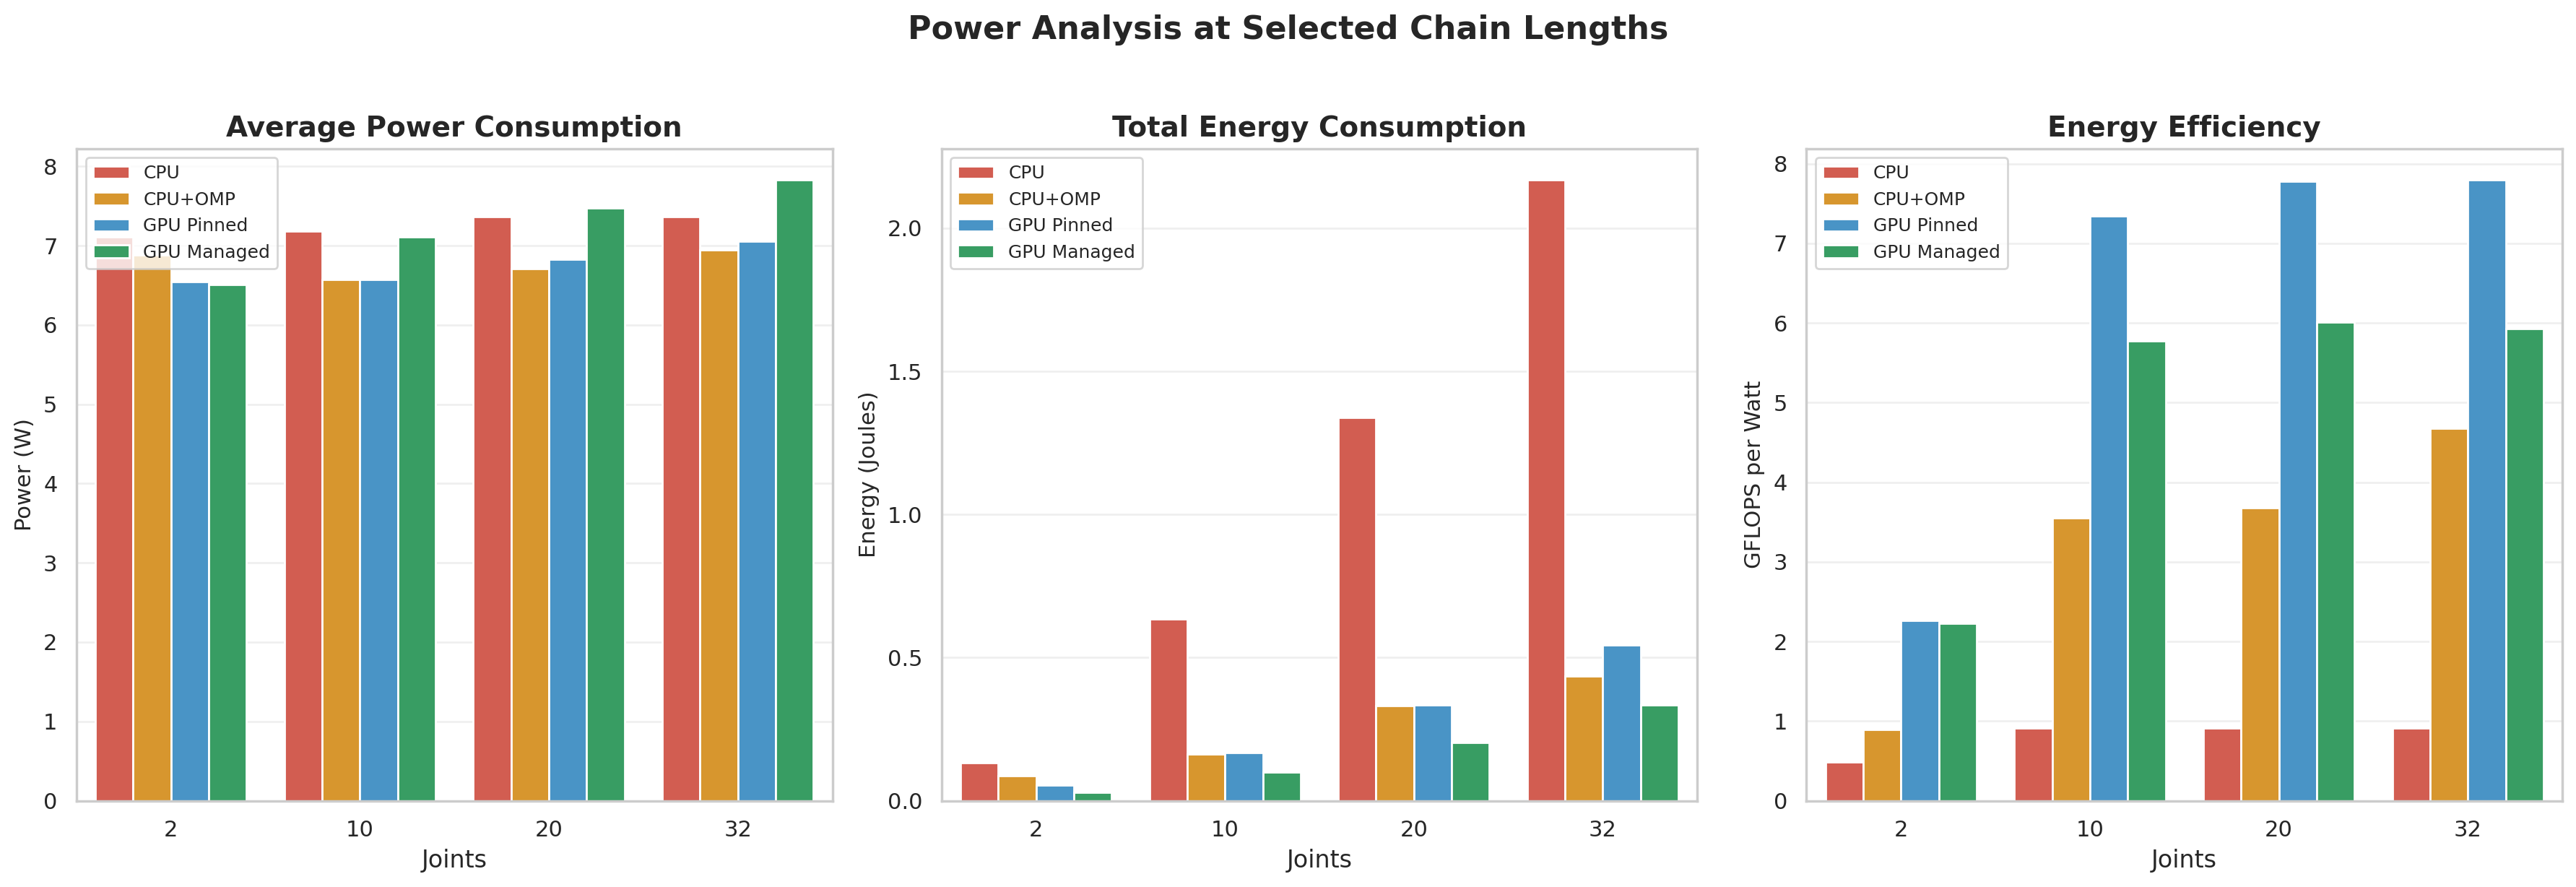

In [ ]:
# Comparative bar chart: Power, Energy, and Efficiency at selected chain lengths
selected_joints = [2, 10, 20, 32]
selected_data = power_summary[power_summary['num_joints'].isin(selected_joints)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)

# Prepare data for plotting
metrics = []
for idx, row in selected_data.iterrows():
    joints = int(row['num_joints'])
    metrics.append({'Joints': joints, 'Method': 'CPU', 'Power (W)': row['CPU_Power_W'], 
                   'Energy (J)': row['CPU_Energy_J'], 'GFLOPS/W': row['CPU_GFLOPS_per_Watt']})
    metrics.append({'Joints': joints, 'Method': 'CPU+OMP', 'Power (W)': row['OMP_Power_W'], 
                   'Energy (J)': row['OMP_Energy_J'], 'GFLOPS/W': row['OMP_GFLOPS_per_Watt']})
    metrics.append({'Joints': joints, 'Method': 'GPU Pinned', 'Power (W)': row['GPU_Pinned_Power_W'], 
                   'Energy (J)': row['GPU_Pinned_Energy_J'], 'GFLOPS/W': row['GPU_Pinned_GFLOPS_per_Watt']})
    if 'GPU_Managed_Power_W' in row and not pd.isna(row['GPU_Managed_Power_W']):
        metrics.append({'Joints': joints, 'Method': 'GPU Managed', 'Power (W)': row['GPU_Managed_Power_W'], 
                       'Energy (J)': row['GPU_Managed_Energy_J'], 'GFLOPS/W': row['GPU_Managed_GFLOPS_per_Watt']})

metrics_df = pd.DataFrame(metrics)

# Define colors
colors = {'CPU': '#e74c3c', 'CPU+OMP': '#f39c12', 'GPU Pinned': '#3498db', 'GPU Managed': '#27ae60'}

# Plot 1: Average Power
sns.barplot(data=metrics_df, x='Joints', y='Power (W)', hue='Method', palette=colors, ax=axes[0])
axes[0].set_title('Average Power Consumption', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Power (W)', fontsize=11)
axes[0].legend(fontsize=9, loc='best')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Total Energy
sns.barplot(data=metrics_df, x='Joints', y='Energy (J)', hue='Method', palette=colors, ax=axes[1])
axes[1].set_title('Total Energy Consumption', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Energy (Joules)', fontsize=11)
axes[1].legend(fontsize=9, loc='best')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Energy Efficiency
sns.barplot(data=metrics_df, x='Joints', y='GFLOPS/W', hue='Method', palette=colors, ax=axes[2])
axes[2].set_title('Energy Efficiency', fontsize=14, fontweight='bold')
axes[2].set_ylabel('GFLOPS per Watt', fontsize=11)
axes[2].legend(fontsize=9, loc='best')
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Power Analysis at Selected Chain Lengths', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()